In [1]:
import torch
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
import winsound
from project.utils import compute_statistics

d:\Programming Files\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.21 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
dte = dtt.now().strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('kess')
fh = logging.FileHandler(f'logs/kess_{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

dte

'Nov_06_2024_124142'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Transformations


In [4]:
import torch
import torch.nn as nn
import math
from torchvision.models import resnet18, ResNet18_Weights

class RPNPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class PretrainedEmbedder(nn.Module):
    def __init__(self, model, weights):
        super().__init__()
        pretrained_model = model(weights=weights)
        no_classifier = list(pretrained_model.children())[:-1]
        self.embedder = nn.Sequential(*(no_classifier))

    def forward(self, x):
        return self.embedder(x)

class SliceEmbedding(nn.Module):
    def __init__(self, image_size, output_dim, in_channels=1, out_channels=1, kernel_size=2, stride=2):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=kernel_size , stride=stride),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=kernel_size, stride=stride),
            nn.ReLU(),
            # nn.Conv2d(in_channels=32, out_channels=32, kernel_size=kernel_size, stride=stride),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=kernel_size, stride=stride),
            nn.Conv2d(in_channels=32, out_channels=24, kernel_size=kernel_size, stride=stride),
            nn.ReLU(),
            
            # nn.Conv2d(in_channels=24, out_channels=24, kernel_size=kernel_size, stride=stride),
            # nn.ReLU(),
            nn.Conv2d(in_channels=24, out_channels=out_channels, kernel_size=kernel_size, stride=stride),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=kernel_size, stride=stride),
            nn.Dropout(0.1),
            nn.Flatten(2)
        )

        # Calculate shape after convolutions
        with torch.inference_mode():
            x = torch.zeros(1, in_channels, image_size, image_size)
            output = self.convs(x)
            final_d = output.numel()

        print(final_d)

        self.mlp = nn.Sequential(
            nn.Linear(final_d, output_dim)
        )


    def forward(self, x):
        out = self.convs(x)
        return self.mlp(out)

class RPN(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 image_size,
                 nh=5,
                 n_layers=1,
                 dim_ff=2500,
                 pretrained=False,
                 embed_model=resnet18,
                 embed_weights=(ResNet18_Weights.IMAGENET1K_V1),
                 *a,
                 **k
                 ):
        super().__init__()

        if pretrained is True:
            self.embedder = PretrainedEmbedder(embed_model, embed_weights)
        else:
            self.embedder = SliceEmbedding(image_size=image_size, output_dim=input_dim)

        # input_dim=512
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nh, dim_feedforward=dim_ff)
        self.trans_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)
        self.posenc = RPNPositionalEncoding(d_model=input_dim)
        self.fc = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.Sigmoid(),
        )

    def forward(self, x, i):

        slices = self.embedder(x)
        slices = slices.view(slices.shape[0], 1, -1)
        slices = self.posenc(slices)
        out = self.trans_encoder(slices)
        out = self.trans_encoder(slices[i])
        out = self.fc(out)

        return out


In [5]:
import albumentations as A 
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import torch
import nibabel as nib
import cv2

def get_transform(height, width, p, rpn_mode):
    if rpn_mode is False:
        return A.Compose(
            [
                A.Resize(
                    height=height, 
                    width=width, 
                    p=p, 
                    always_apply=True
                ),
                ToTensorV2(p=p)
            ],
            is_check_shapes=False
        )
    else:
        return A.Compose(
            [
                A.Resize(
                    height=height, 
                    width=width, 
                    p=p, 
                    always_apply=True
                ),
                ToTensorV2(p=p)
            ],
            p=p,
            bbox_params=A.BboxParams(
                format='pascal_voc',
                min_area=0,
                min_visibility=0,
                label_fields=['labels']
            )
        )

class NiftiToTensorTransform:
    def __init__(self, target_shape=(512,512), in_channels=1, rpn_mode=False, normalization=None):
        self.target_shape = target_shape
        self.in_channels = in_channels
        self.transform = get_transform(
            height=target_shape[0],
            width=target_shape[1],
            p=1.0,
            rpn_mode=rpn_mode
        )
        self.rpn_mode = rpn_mode
        self.normalization = normalization
        
    def convert_to_binary_mask(self, segmentation_mask):
        binary_mask = (segmentation_mask > 0).astype(np.uint8)
        return binary_mask

    def extract_bounding_boxes(self, mask):
        # Extract bounding boxes from mask
        boxes = []
        contours, _ = cv2.findContours(
            mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            boxes.append([x-10, y-10, x + w+10, y + h+10])
        return boxes
    
    def normalize_slice(self, slice):
        min, max = self.normalization
        slice = (slice - min) / (max - min)
        
        return slice

    def __call__(self, mri_image_path, segmentation_mask_path):
        try:
            mri_image = nib.load(mri_image_path).get_fdata()
            segmentation_mask = nib.load(segmentation_mask_path).get_fdata()
            
            if self.normalization is not None:
                mri_image = np.stack([self.normalize_slice(mri_image[:, :, i]) for i in range(mri_image.shape[2])], axis=-1)
                
            segmentation_mask = self.convert_to_binary_mask(segmentation_mask) # USE THIS
            
            image_slices = []
            mask_slices = []
            
            if self.rpn_mode == False:
                for i in range(mri_image.shape[2]):
                    augmented = self.transform(
                        image=mri_image[:, :, i], 
                        mask=segmentation_mask[:, :, i]
                    )
                
                    image_slices.append(augmented['image'].unsqueeze(0)) 
                    mask_slices.append(augmented['mask'].unsqueeze(0))   
    
                image = torch.stack(image_slices) 
                mask = torch.stack(mask_slices)  
            
                if image.shape[1] != 1 or mask.shape[1] != 1:
                    raise ValueError("Unexpected number of slices in the MRI image or segmentation mask.")

                return image, mask

            else: # RPN transformation
                for i in range(mri_image.shape[2]):
                    boxes = self.extract_bounding_boxes(segmentation_mask[:, :, i])
                    if boxes:
                        augmented = self.transform(
                            image=mri_image[:, :, i],
                            bboxes=boxes,
                            labels=[1]*len(boxes)
                        )
                        img_slice = augmented['image']
                        boxes = torch.tensor(augmented['bboxes'], dtype=torch.float32)
                        labels = augmented['labels']
                    else:
                        augmented = self.transform(
                            image=mri_image[:, :, i],
                            bboxes=[],
                            labels=[]
                        )
                        img_slice = augmented['image']
                        boxes = torch.zeros((1, 4), dtype=torch.float32)
                        labels = augmented['labels']
                    
                    image_slices.append(img_slice.unsqueeze(0))
                    boxes = torch.clamp(boxes, min=0, max=self.target_shape[0])
                    mask_slices.append(boxes.unsqueeze(0))
            
                # image = torch.stack(image_slices) 
                # mask = torch.stack(mask_slices)  
                image = [image_slices]
                mask = [mask_slices]
                
                return image, mask
            
                # if image.shape[1] != 1 or mask.shape[1] != 1:
                #     raise ValueError("Unexpected number of slices in the MRI image or segmentation mask.")
        
        except Exception as e:
            print(f"Error in __call__ with {mri_image} and {segmentation_mask}: {e}")
            return None, None


### Config for fitter


In [6]:
from project.model import RPN
import torch.nn as nn

config = {
    'model': RPN(
        input_dim=512,
        output_dim=4,
        image_size=300,
        nh=4,
        pretrained=True
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 30,
    'loss': nn.SmoothL1Loss(),
    'lr': 0.0001
}

d:\Programming Files\Python\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Load dataset


In [7]:
ds = Dataset()

data = pd.read_csv('targets.csv')
data.shape

(7986, 7)

In [8]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
data

,mri,masks,target,has_microbleed_case,has_microbleed_slice,cohort,max_value
0,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,8,1,1,1,928.405273
1,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,9,1,1,1,928.405273
2,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,11,1,1,1,928.405273
3,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,12,1,1,1,928.405273
4,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,15,1,1,1,928.405273
...,...,...,...,...,...,...,...
359,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,241.000000
360,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,26,1,1,3,241.000000
361,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,24,1,1,3,448.000000
362,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,448.000000


### `DataLoader` Generator


In [9]:
def collatev2(batch):
    images = []
    masks = []
    targets = []
    cases = []

    for item in batch:
        image, mask, target, case = item
        
        images.append(image)
        masks.append(mask)
        targets.append(target)
        cases.append(case)

    return images, masks, targets, cases

In [10]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 batch_size,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None
                ):
    data = data[data.cohort == cohort]
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.mri.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.mri.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.mri.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    # train_loader = DataLoader(
    #     train_set,
    #     shuffle=True,
    #     batch_size=batch_size,
    #     collate_fn=collatev2
    # )
    # val_loader = DataLoader(
    #     val_set,
    #     shuffle=True,
    #     batch_size=batch_size,
    #     collate_fn=collatev2
    # )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_set, val_set

### Fitter


In [11]:
from project import Fitter

class RPNFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        self.model.to(self.device)
        counter = 0
        total_loss = 0
        loss_history = []
        
        for batch in train_loader:
            images, masks, targets, cases = batch
            
            for slices, masks, target, case in zip(images, masks, targets, cases):
                x = torch.stack(slices[0]).squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                processed_masks = masks[0][target].float().to(self.device)/300
                
                self.optimizer.zero_grad()
                outputs = self.model(x, target)
                
                batch_loss = self.loss(outputs, processed_masks)
                batch_loss.backward()  
                self.optimizer.step()
                counter += 1
                
                self.log(f'Batch:\t{counter}/{len(train_loader)}')
                self.log(f'Batch samples:\t{len(batch)}')
                total_loss += batch_loss.item()
                self.logger.info(f"Current Loss: {batch_loss.item()}")
            
                loss_history.append(batch_loss.detach().cpu().numpy())

        return loss_history

    def validation(self, val_loader):
        self.model.eval()
        total_loss = 0
        loss_history = []
        
        with torch.inference_mode():  
            for batch in val_loader:
                images, masks, targets, cases = batch
                
                for slices, masks, target, case in zip(images, masks, targets, cases):
                    x = torch.stack(slices[0]).squeeze(1).repeat(1, 3, 1, 1).float().to(device)
                    processed_masks = masks[0][target].float().to(self.device)/300
                    
                    outputs = self.model(x, target)
                    loss = self.loss(outputs, processed_masks)
                    total_loss += loss.item()
            
                loss_history.append(loss.detach().cpu().numpy())

        return loss_history

            

In [12]:
fitter = RPNFitter(config, logger=logger)

### Training


In [13]:
t1, v1 = make_loaders(
    data=data,
    cohort=1,
    batch_size=4
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 7), (9, 7))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)



In [14]:
t3, v3 = make_loaders(
    data=data,
    cohort=3,
    batch_size=4
)

Creating loaders for Cohort 3
TRAIN & TEST: ((37, 7), (10, 7))
Total Unique MRI Samples in data_train: 26
GLOBAL MIN & MAX (0.0, 664.0)



In [15]:
from torch.utils.data import ConcatDataset

train_set = ConcatDataset([t1, t3])
val_set = ConcatDataset([v1, v3])

In [16]:
tl = DataLoader(
    train_set,
    shuffle=True,
    batch_size=5,
    collate_fn=collatev2
)
vl = DataLoader(
    val_set,
    shuffle=True,
    batch_size=5,
    collate_fn=collatev2
)


In [17]:
thist, vhist = fitter.fit(tl, vl)

INFO:kess:EPOCH 0 ==============================
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
d:\Programming Files\Python\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
d:\Programming Files\Python\Lib\site-packages\torch\nn\modules\loss.py:939: UserWarning: Using a target size (torch.Size([1, 1, 4])) that is different to the input size (torch.Size([1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=se

In [18]:
winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

<Axes: >

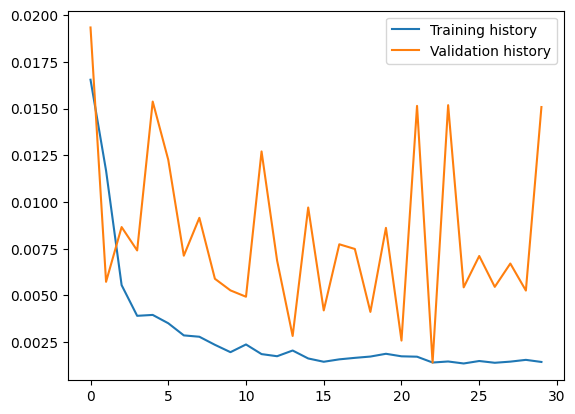

In [19]:
import seaborn as sns
import numpy as np

th = torch.tensor(np.array(thist))
vh = torch.tensor(np.array(vhist))
# print(th.shape)
sns.lineplot(th.mean(1), label='Training history')
sns.lineplot(vh.mean(1), label='Validation history')

# Trial


In [20]:
model = fitter.model

In [21]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pr_bbox bbox [157.30149841308594, 129.3110809326172, 174.82835388183594, 124.90585327148438]


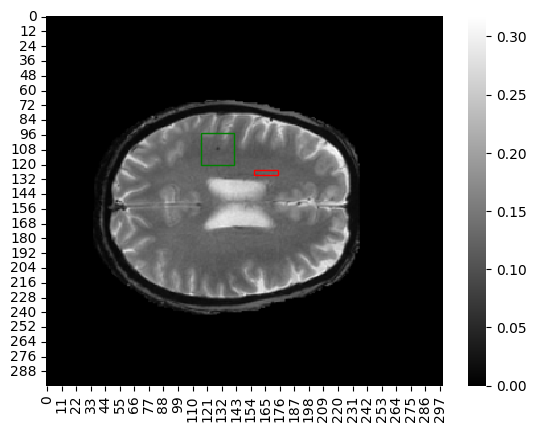

pr_bbox bbox [97.24272918701172, 127.86268615722656, 117.49388122558594, 128.1423797607422]


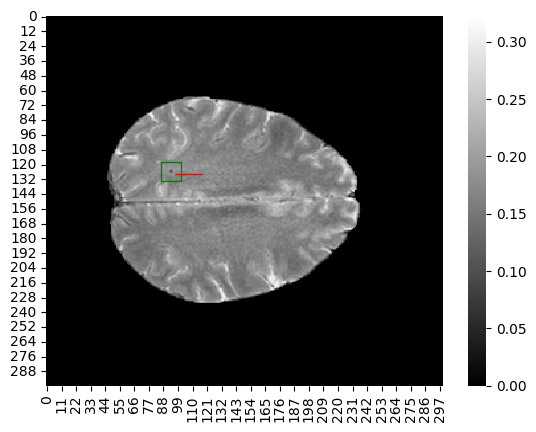

pr_bbox bbox [79.54529571533203, 118.79808044433594, 95.5899887084961, 117.3584213256836]


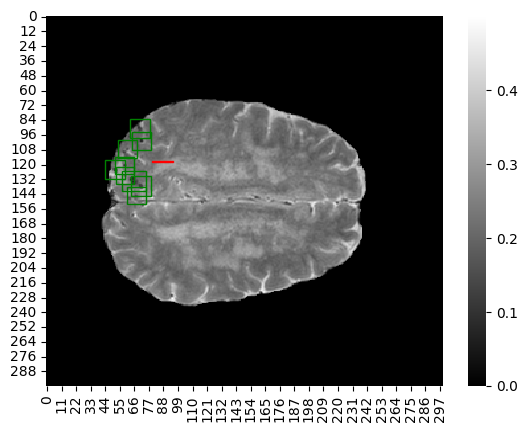

pr_bbox bbox [107.67495727539062, 168.75271606445312, 120.28368377685547, 162.31948852539062]


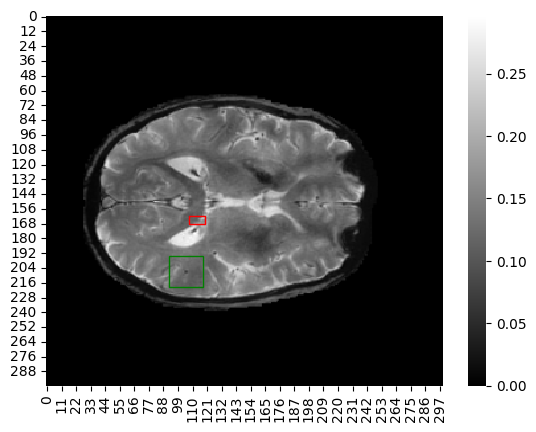

pr_bbox bbox [99.17463684082031, 147.13685607910156, 113.57079315185547, 132.78770446777344]


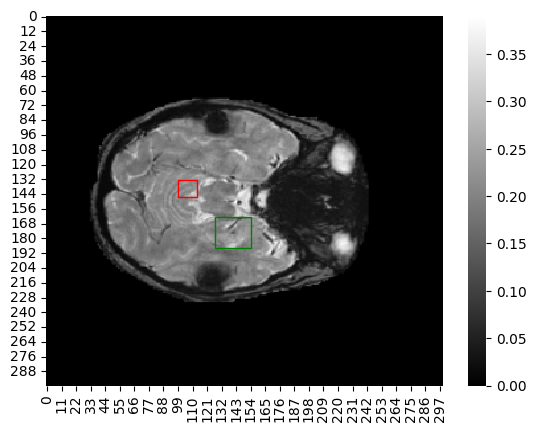

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pr_bbox bbox [69.6314468383789, 141.8605499267578, 81.92607116699219, 141.2210235595703]


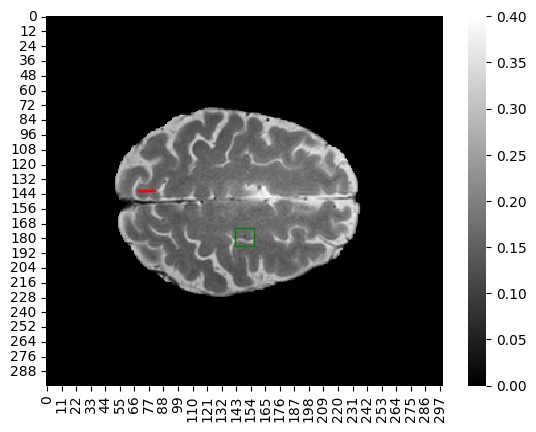

pr_bbox bbox [126.03117370605469, 150.46656799316406, 143.2380828857422, 147.1395721435547]


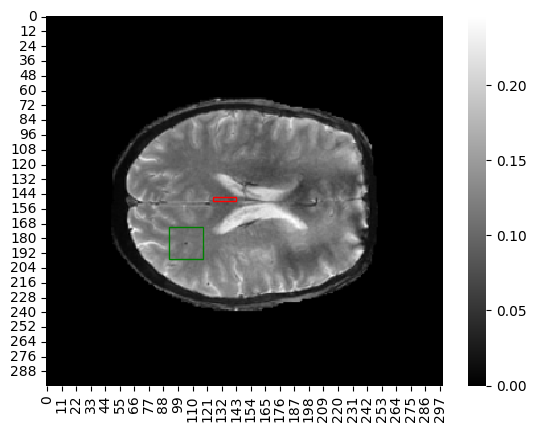

pr_bbox bbox [85.40704345703125, 180.18896484375, 103.99161529541016, 166.00296020507812]


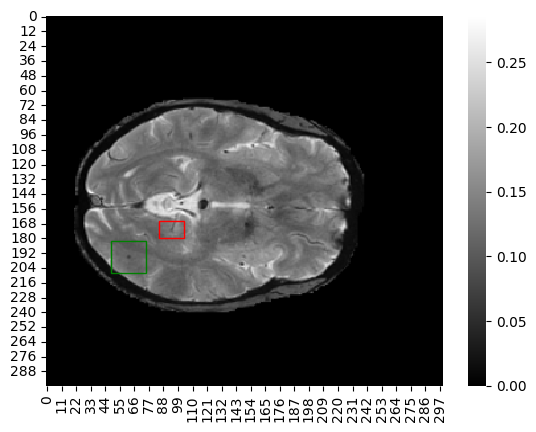

pr_bbox bbox [102.99629974365234, 170.18844604492188, 121.12921142578125, 154.88943481445312]


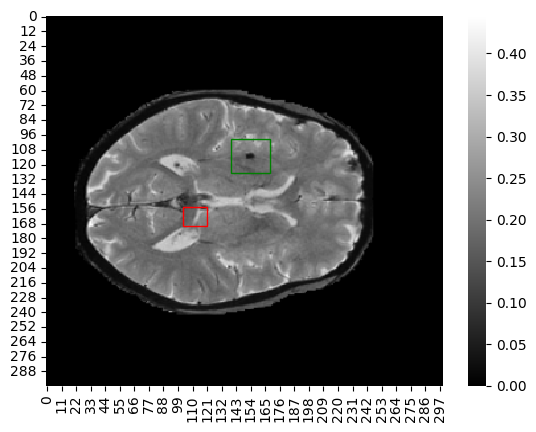

pr_bbox bbox [81.83078002929688, 141.42044067382812, 99.58545684814453, 139.669189453125]


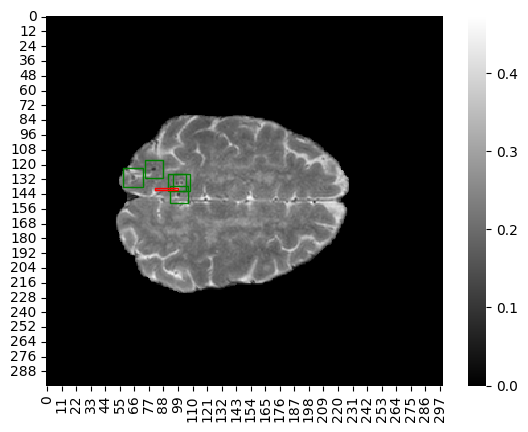

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pr_bbox bbox [115.44727325439453, 146.97042846679688, 130.4573211669922, 135.94586181640625]


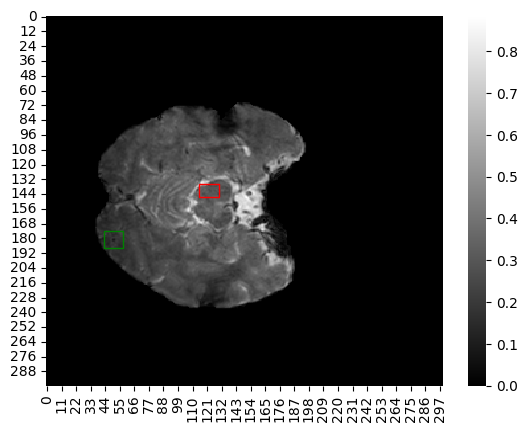

pr_bbox bbox [108.65874481201172, 160.08592224121094, 120.45885467529297, 141.141357421875]


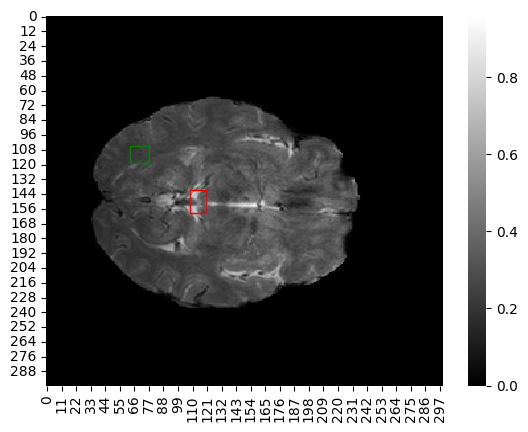

pr_bbox bbox [133.9100341796875, 164.5796356201172, 149.8091278076172, 153.73211669921875]


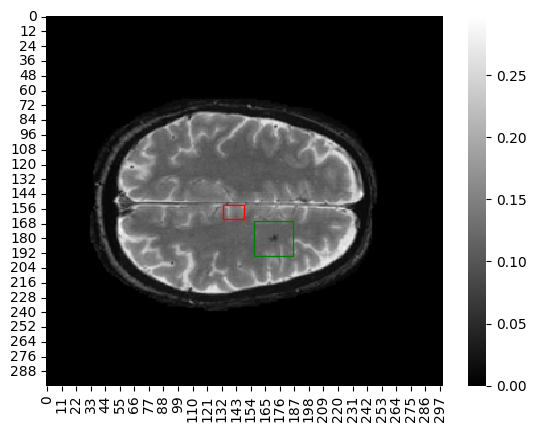

pr_bbox bbox [108.24728393554688, 175.30307006835938, 122.96626281738281, 172.59153747558594]


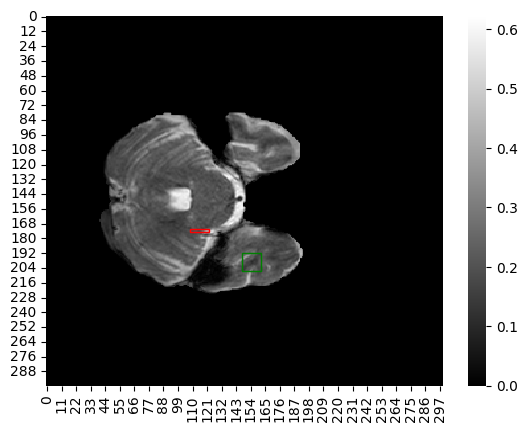

pr_bbox bbox [69.64115905761719, 180.31735229492188, 85.25332641601562, 168.0013427734375]


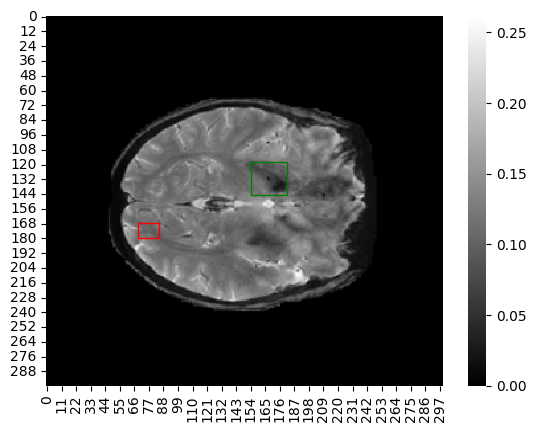

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pr_bbox bbox [73.989501953125, 155.1652374267578, 92.35697937011719, 150.2129364013672]


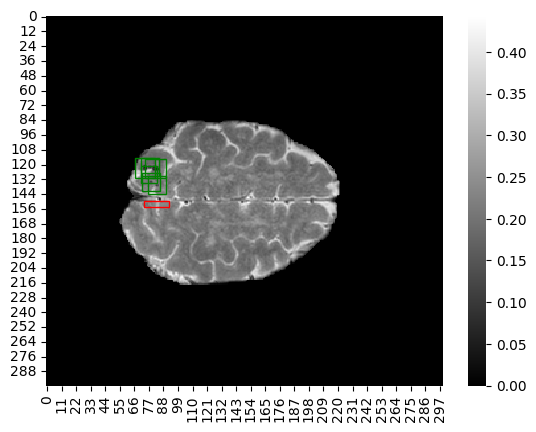

pr_bbox bbox [50.39116287231445, 166.92755126953125, 69.71102142333984, 154.81005859375]


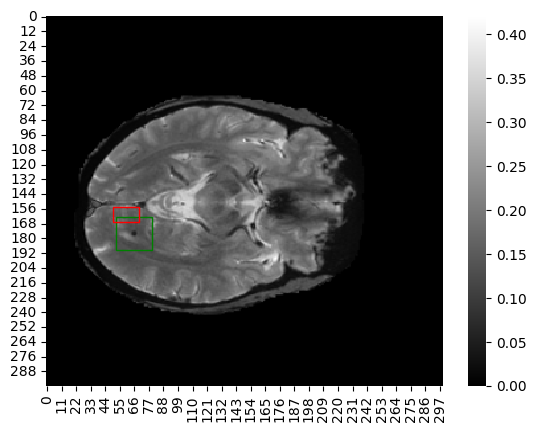

pr_bbox bbox [92.4106674194336, 131.6067657470703, 105.45247650146484, 130.21343994140625]


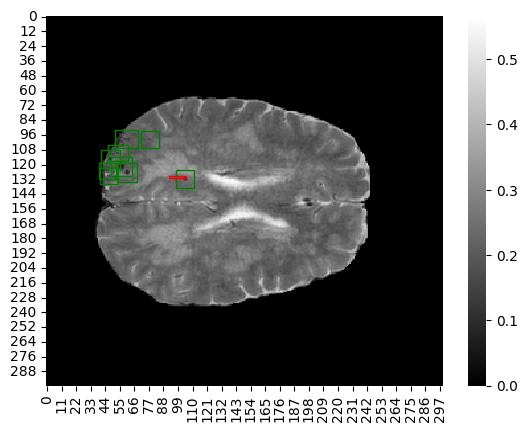

pr_bbox bbox [161.96971130371094, 133.91348266601562, 180.20217895507812, 133.3775177001953]


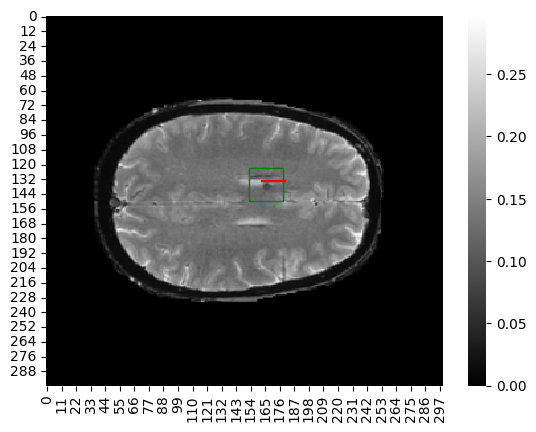

In [22]:
for index, batch in enumerate(vl):
    # for i in range(len(batch)):
        images, masks, targets, cases = batch
        
        for slices, masks, target, case in zip(images, masks, targets, cases):
            slices = torch.stack(slices[0]).squeeze(1).float().repeat(1, 3, 1, 1).to(device)
            masks = masks[0]
            
            y = model(slices, target)
            gt_bboxes = masks[target].cpu().numpy()
            pr_bboxes = [(y * 300).squeeze().detach().cpu().tolist()]
            
            fig, ax = plt.subplots()
            ax = sns.heatmap(slices[target][0].squeeze().cpu(), cmap='gray')
            
            for gt_bbox in gt_bboxes[0]: 
                truth = patches.Rectangle(
                    (gt_bbox[0], gt_bbox[1]), 
                    gt_bbox[2] - gt_bbox[0],  
                    gt_bbox[3] - gt_bbox[1], 
                    linewidth=1, edgecolor='g', facecolor='none'
                )
                ax.add_patch(truth)

            for pr_bbox in pr_bboxes:
                print('pr_bbox bbox', pr_bbox)
                pred = patches.Rectangle(
                    (pr_bbox[0], pr_bbox[1]),
                    pr_bbox[2] - pr_bbox[0],
                    pr_bbox[3] - pr_bbox[1],
                    linewidth=1, edgecolor='r', facecolor='none'
                )
                ax.add_patch(pred)
                
            plt.show()
        
    